## Kai Yang
## <kai.yang2 "at" mail.mcgill.ca>
## License :: OSI Approved :: GNU Affero General Public License v3 or later (AGPLv3+)
## [GPG Public key Fingerprint: CC02CF153594774CF956691492B2600D18170329](https://keys.openpgp.org/vks/v1/by-fingerprint/CC02CF153594774CF956691492B2600D18170329)

In [1]:
import ctypes as _ctypes
import warnings as _warnings

import multiprocess as _mp
import numpy as _np
import pandas as _pd
from dask import dataframe as _dd
from KDEpy import FFTKDE as _FFTKDE
from KDEpy.bw_selection import improved_sheather_jones as _improved_sheather_jones
from KDEpy.bw_selection import scotts_rule as _scotts_rule
from KDEpy.bw_selection import silvermans_rule as _silvermans_rule

# from bed_reader import open_bed as _open_bed
from numba import jit as _jit
from numba import njit as _njit
from sklearn.decomposition import PCA as _PCA
from sklearn.feature_selection import mutual_info_classif as _mutual_info_classif
from sklearn.feature_selection import mutual_info_regression as _mutual_info_regression
from sklearn.preprocessing import RobustScaler as _scaler
from tqdm import tqdm as _tqdm

_warnings.filterwarnings("ignore")

/home/alphaito/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# basic functions

In [2]:
def _open_bed():
    print(
        "bed_reader might have some bugs for this version, causing it not running"
    )
    pass

In [3]:
# the FFT-based direct integration actually under-performs forward Euler in many scenerios...
def fft_diff(x, order=1, period=None, integrate_from_zero=False):
    """
    This is a function calculates quadrature using FFT directly. This is pretty much scipy.fftpack.diff but in numpy.
    """
    x = _np.asarray(x)
    N = x.shape[0]

    # If period is not specified, use the length of the signal
    if period is None:
        period = N

    # Compute the frequency indices for FFT. Adjusted to match the period
    k = _np.fft.fftfreq(N, d=period / N)

    # Perform the FFT
    fx = _np.fft.fft(x)

    # Factor for differentiation or integration in the frequency domain
    if order > 0:
        factor = (1j * 2 * _np.pi * k)**order
    else:
        factor = 1 / ((1j * 2 * _np.pi * k)**abs(order))
        factor[k == 0] = 0  # Avoid division by zero for zero frequency

    fx *= factor

    # Perform the inverse FFT
    result = _np.fft.ifft(fx)

    # For integration, adjust to start from zero if needed
    if order < 0 and integrate_from_zero:
        result -= result[0]

    return result.real

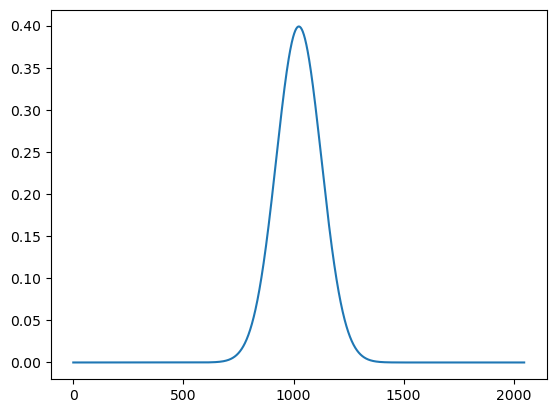

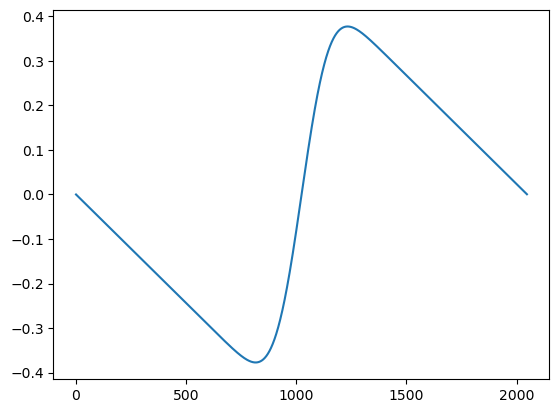

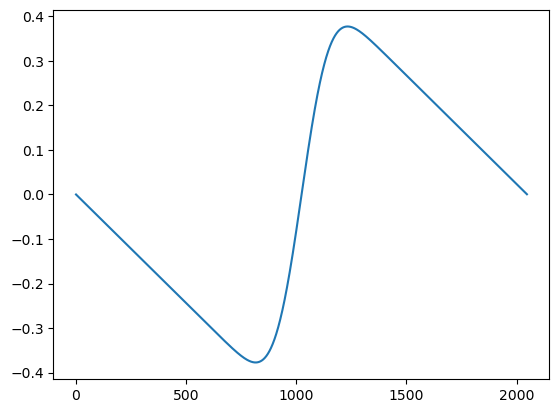

FFT integration gives the entropy:  -0.0006928410806663313
forward Euler integration gives the entropy:  -1.4189385332046727
analytic evaluation gives the entropy:  -1.4189385332046727


In [4]:
import matplotlib.pyplot as plt
from scipy.fftpack import diff
from scipy.stats import norm

# this pretty much shows that quadrature using FFT is not a good idea for density-based functions.
x = _np.linspace(-10, 10, 2048, endpoint=False)
y = norm.pdf(x, loc=0, scale=1)
plt.plot(y)
plt.show()
plt.plot(fft_diff(y, period=20, order=-1, integrate_from_zero=True))
plt.show()
plt.plot(diff(y, period=20, order=-1))
plt.show()

# for entropy calculation, this shows that numerical integration should use forward Euler instead of FFT
x = _np.linspace(-10, 10, 2048, endpoint=False)
y = norm.pdf(x, loc=0, scale=1)
FFT_integral_entropy = fft_diff(y * _np.log(y),
                                period=20,
                                order=-1,
                                integrate_from_zero=True)
print("FFT integration gives the entropy: ", _np.max(FFT_integral_entropy[-1]))
forward_euler_integral_entropy = _np.sum(y * _np.log(y)) * (x[1] - x[0])
print("forward Euler integration gives the entropy: ",
      forward_euler_integral_entropy)
print("analytic evaluation gives the entropy: ",
      -(0.5 * _np.log(2 * _np.pi * 1) + 0.5))

In [5]:
%load_ext cython

In [6]:
%%cython -a

import numpy as _np
from cython.parallel import prange
from cython cimport floating
from libc.math cimport log, isfinite, pow, fmax
from libc.stdlib cimport calloc, free, qsort, malloc
cimport cython
ctypedef fused floating_float_double:
    float
    double


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def joint_to_mi_cython(floating_float_double[:, ::1] joint, floating_float_double forward_euler_a=1., floating_float_double forward_euler_b=1.):
    cdef int i, j
    cdef int joint_shape0 = joint.shape[0]
    cdef int joint_shape1 = joint.shape[1]
    cdef floating_float_double * log_a_marginal = <floating_float_double*>calloc(joint_shape0, sizeof(floating_float_double))
    cdef floating_float_double * log_b_marginal = <floating_float_double*>calloc(joint_shape1, sizeof(floating_float_double))
    cdef floating_float_double temp_sum, log_val, log_temp_sum, log_forward_euler_a, log_forward_euler_b, log_joint, output

    if log_a_marginal == NULL or log_b_marginal == NULL:
        raise MemoryError("Failed to allocate memory.")

    log_forward_euler_a = log(forward_euler_a)
    log_forward_euler_b = log(forward_euler_b)
    temp_sum = 0.0

    for i in prange(joint_shape0, nogil=True):
        for j in prange(joint_shape1):
            log_a_marginal[i] += joint[i, j]
            log_b_marginal[j] += joint[i, j]
        temp_sum += log_a_marginal[i]

    temp_sum *= forward_euler_a * forward_euler_b
    log_temp_sum = log(temp_sum)

    for i in prange(joint_shape0, nogil=True):
        log_val = log(log_a_marginal[i])
        log_a_marginal[i] = log_val + \
            log_forward_euler_b if isfinite(log_val) else 0.0

    for j in prange(joint_shape1, nogil=True):
        log_val = log(log_b_marginal[j])
        log_b_marginal[j] = log_val + \
            log_forward_euler_a if isfinite(log_val) else 0.0

    output = 0.0
    for i in prange(joint_shape0, nogil=True):
        for j in prange(joint_shape1):
            log_joint = log(joint[i, j]) if isfinite(log(joint[i, j])) else 0.0
            output += joint[i, j] * (log_joint - log_a_marginal[i] -
                                     log_b_marginal[j]) * forward_euler_a * forward_euler_b

    output = max(output, 0.0)

    free(log_a_marginal)
    free(log_b_marginal)

    return output


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef double hist_obj_cython(floating_float_double[:] x, int D):
    """
    Calculate the value of the objective function for histogram binning.
    """
    cdef int N = x.shape[0]
    cdef int * N_j
    cdef int i, bin_index
    cdef double x_min, x_max, bin_width, result = 0.0, total_sum = 0.0
    cdef floating_float_double xi

    # Initialize min and max
    x_min = x_max = x[0]
    for i in range(N):
        if x[i] < x_min:
            x_min = x[i]
        if x[i] > x_max:
            x_max = x[i]

    # Allocate memory for histogram counts
    N_j = <int*>calloc(D, sizeof(int))
    if N_j == NULL:
        raise MemoryError("Failed to allocate memory for histogram counts.")

    # Calculate bin width
    bin_width = (x_max - x_min) / D

    # Histogram calculation
    for i in range(N):
        xi = x[i]
        bin_index = <int > ((xi - x_min) / bin_width)
        if bin_index >= D:
            bin_index = D - 1
        N_j[bin_index] += 1

    # Objective function calculation
    for i in range(D):
        if N_j[i] > 0:
            result += N_j[i] * log(N_j[i])
            total_sum += N_j[i]

    result += total_sum * log(D) - (D - 1 + log(D) ** 2.5)

    # Free allocated memory
    free(N_j)

    return result


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int num_of_bins_cython(floating_float_double[:] x):
    """
    Calculate the optimal number of bins for histogram binning.
    """
    cdef int D, max_D = 2
    cdef double max_obj = -1e20, current_obj
    cdef int N = x.shape[0]

    # Search for the optimal number of bins from 2 to 100
    for D in range(2, 100):
        current_obj = hist_obj_cython(x, D)
        if current_obj > max_obj:
            max_obj = current_obj
            max_D = D

    return max_D


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double binning_MI_cython(floating_float_double[:] a, floating_float_double[:] b):
    """
    Calculate mutual information using binning for two 1-D arrays a and b.
    """
    cdef int N = a.shape[0]
    cdef int D_a = num_of_bins_cython(a)
    cdef int D_b = num_of_bins_cython(b)
    cdef int * histogram
    cdef double * normalized_histogram_ptr
    cdef double[:, ::1] joint_2d
    cdef int i, j, bin_index_a, bin_index_b
    cdef double a_min, a_max, b_min, b_max, bin_width_a, bin_width_b, total = 0.0
    cdef floating_float_double ai, bi

    # Initialize min and max for a and b
    a_min, a_max = a[0], a[0]
    b_min, b_max = b[0], b[0]
    for i in range(N):
        if a[i] < a_min:
            a_min = a[i]
        if a[i] > a_max:
            a_max = a[i]
        if b[i] < b_min:
            b_min = b[i]
        if b[i] > b_max:
            b_max = b[i]

    # Allocate memory for 2D histogram
    histogram = <int*>calloc(D_a * D_b, sizeof(int))
    if histogram == NULL:
        raise MemoryError("Failed to allocate memory for 2D histogram.")

    # Calculate bin widths
    bin_width_a = (a_max - a_min) / D_a
    bin_width_b = (b_max - b_min) / D_b

    # 2D Histogram calculation
    for i in range(N):
        ai = a[i]
        bi = b[i]
        bin_index_a = <int > ((ai - a_min) / bin_width_a)
        bin_index_b = <int > ((bi - b_min) / bin_width_b)
        if bin_index_a >= D_a:
            bin_index_a = D_a - 1
        if bin_index_b >= D_b:
            bin_index_b = D_b - 1
        histogram[bin_index_a * D_b + bin_index_b] += 1

    # Allocate memory for normalized histogram
    normalized_histogram_ptr = <double * > calloc(D_a * D_b, sizeof(double))
    if normalized_histogram_ptr == NULL:
        raise MemoryError(
            "Failed to allocate memory for normalized histogram.")

    # Normalize histogram to get joint probability
    total = 0.0
    for i in range(D_a * D_b):
        total += histogram[i]
    for i in range(D_a):
        for j in range(D_b):
            normalized_histogram_ptr[i * D_b +
                                     j] = histogram[i * D_b + j] / total

    # Wrap the normalized histogram pointer as a 2D memory view
    joint_2d = <double[:D_a, :D_b] > normalized_histogram_ptr

    # Calculate mutual information
    mi = joint_to_mi_cython(joint_2d)

    # Free allocated memory
    free(histogram)
    free(normalized_histogram_ptr)

    return mi


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double binning_MI_discrete_cython(floating_float_double[:] a, floating_float_double[:] b):
    """
    Calculate mutual information using binning for two 1-D arrays a and b.
    """
    cdef int N = a.shape[0]
    cdef int D_a = len(_np.unique(a))
    cdef int D_b = num_of_bins_cython(b)
    cdef int * histogram
    cdef double * normalized_histogram_ptr
    cdef double[:, ::1] joint_2d
    cdef int i, j, bin_index_a, bin_index_b
    cdef double a_min, a_max, b_min, b_max, bin_width_a, bin_width_b, total = 0.0
    cdef floating_float_double ai, bi

    # Initialize min and max for a and b
    a_min, a_max = a[0], a[0]
    b_min, b_max = b[0], b[0]
    for i in range(N):
        if a[i] < a_min:
            a_min = a[i]
        if a[i] > a_max:
            a_max = a[i]
        if b[i] < b_min:
            b_min = b[i]
        if b[i] > b_max:
            b_max = b[i]

    # Allocate memory for 2D histogram
    histogram = <int*>calloc(D_a * D_b, sizeof(int))
    if histogram == NULL:
        raise MemoryError("Failed to allocate memory for 2D histogram.")

    # Calculate bin widths
    bin_width_a = (a_max - a_min) / D_a
    bin_width_b = (b_max - b_min) / D_b

    # 2D Histogram calculation
    for i in range(N):
        ai = a[i]
        bi = b[i]
        bin_index_a = <int > ((ai - a_min) / bin_width_a)
        bin_index_b = <int > ((bi - b_min) / bin_width_b)
        if bin_index_a >= D_a:
            bin_index_a = D_a - 1
        if bin_index_b >= D_b:
            bin_index_b = D_b - 1
        histogram[bin_index_a * D_b + bin_index_b] += 1

    # Allocate memory for normalized histogram
    normalized_histogram_ptr = <double * > calloc(D_a * D_b, sizeof(double))
    if normalized_histogram_ptr == NULL:
        raise MemoryError(
            "Failed to allocate memory for normalized histogram.")

    # Normalize histogram to get joint probability
    total = 0.0
    for i in range(D_a * D_b):
        total += histogram[i]
    for i in range(D_a):
        for j in range(D_b):
            normalized_histogram_ptr[i * D_b +
                                     j] = histogram[i * D_b + j] / total

    # Wrap the normalized histogram pointer as a 2D memory view
    joint_2d = <double[:D_a, :D_b] > normalized_histogram_ptr

    # Calculate mutual information
    mi = joint_to_mi_cython(joint_2d)

    # Free allocated memory
    free(histogram)
    free(normalized_histogram_ptr)

    return mi

In [7]:
def _hist_obj(x, D):
    """
    For a given 1-D array x and given number of bins D, calculate the value of the objective function based on the method given in "How many bins should be put in a regular histogram" by Birge and Rozenholc.
    """
    N_j, _ = _np.histogram(
        x, bins=D)  # to get the number of data points in each bin
    return (_np.sum(N_j * _np.log(N_j)) + len(x) * _np.log(D) -
            (D - 1 + _np.log(D)**2.5))


def _num_of_bins(x):
    """
    For a given 1-D array x, calculate the number of bins based on the method given in "How many bins should be put in a regular histogram" by Birge and Rozenholc.
    """
    D_list = _np.arange(
        2, 100)  # search for the optimal number of bins from 2 to 100
    D_obj_list = _np.array([hist_obj_cython(x, D) for D in D_list])
    return D_list[_np.nanargmax(D_obj_list)]


def _binning_MI(a, b):
    """
    For two 1-D arrays continuous a, b; calculate their mutual information using binning.
    """
    joint, _, _ = _np.histogram2d(
        a, b, bins=(_num_of_bins(a), _num_of_bins(b)))
    joint /= _np.sum(joint)
    # Convert joint to a contiguous array for performance
    joint = _np.ascontiguousarray(joint)
    return joint_to_mi_cython(joint)


def _binning_MI_discrete(a, b):
    """
    For two 1-D arrays discrete a and continuous b; calculate their mutual information using binning.
    """
    joint, _, _ = _np.histogram2d(a,
                                  b,
                                  bins=(len(_np.unique(a)), _num_of_bins(b)))
    joint /= _np.sum(joint)
    # Convert joint to a contiguous array for performance
    joint = _np.ascontiguousarray(joint)
    return joint_to_mi_cython(joint)

In [8]:
# testing block for the above functions to calculate the number of bins and binning mutual information
x = _np.random.normal(size=100)

# test hist_obj_cython
print(hist_obj_cython(x, 10) - _hist_obj(x, 10), "-- should be 0")
%timeit hist_obj_cython(x, 10)
%timeit _hist_obj(x, 10)

# test num_of_bins_cython
print(num_of_bins_cython(x) - _num_of_bins(x), "-- should be 0")
%timeit num_of_bins_cython(x)
%timeit _num_of_bins(x)
num_of_bins_cython(x)

# test binning_MI_cython
x, y = _np.random.normal(size=100), _np.random.normal(size=100)
print(binning_MI_cython(x, y) - _binning_MI(x, y), "-- should be 0")
%timeit binning_MI_cython(x, y)
%timeit _binning_MI(x, y)
binning_MI_cython(x, y)

# test binning_MI_discrete_cython
x, y = _np.random.binomial(1, 0.3, size=100), _np.random.normal(size=100)
x = x.astype(
    float
)  # this is just to ensure that signature used in Cython is valid for the discrete variable
print(
    binning_MI_discrete_cython(x, y) - _binning_MI_discrete(x, y),
    "-- should be 0")
%timeit binning_MI_cython(x, y)
%timeit _binning_MI(x, y)
binning_MI_discrete_cython(x, y)

0.0 -- should be 0
550 ns ± 7.68 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
29 µs ± 287 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
0 -- should be 0
34.3 µs ± 395 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
78.6 µs ± 522 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
0.0 -- should be 0
80.4 µs ± 746 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
239 µs ± 760 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
0.0 -- should be 0
63.4 µs ± 278 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
222 µs ± 572 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


0.016799070137481185

In [9]:
@_njit(cache=True)
def _nan_inf_to_0(x):
    """
    Convert NaN and infinity values in a NumPy array to zero.
    """
    return _np.where(_np.isfinite(x), x, 0.0)


@_njit(cache=True)
def _compute_log_marginals(joint, forward_euler_a, forward_euler_b):
    """
    Compute log marginals from a joint distribution.
    """
    log_marginal_x = _np.log(_np.sum(joint, axis=1)) + _np.log(forward_euler_b)
    log_marginal_y = _np.log(_np.sum(joint, axis=0)) + _np.log(forward_euler_a)
    return _nan_inf_to_0(log_marginal_x), _nan_inf_to_0(log_marginal_y)


@_njit(cache=True)
def _joint_to_mi(joint, forward_euler_a=1.0, forward_euler_b=1.0):
    """
    Calculate mutual information from a joint distribution.
    """
    joint /= _np.sum(joint) * forward_euler_a * forward_euler_b
    log_marginal_a, log_marginal_b = _compute_log_marginals(
        joint, forward_euler_a, forward_euler_b)
    log_joint = _nan_inf_to_0(_np.log(joint))
    mi_temp = (_np.sum(joint * (log_joint - log_marginal_a.reshape(-1, 1) -
                                log_marginal_b.reshape(1, -1))) *
               forward_euler_a * forward_euler_b)
    return max(mi_temp, 0.0)


def _select_bandwidth(input_var, bw_multiplier, bw="silverman"):
    """
    Select bandwidth for univariate data.
    """
    bandwidth_functions = {
        "silverman": _silvermans_rule,
        "scott": _scotts_rule,
        "ISJ": _improved_sheather_jones,
    }

    if isinstance(bw, str):
        _bw = bandwidth_functions[bw](input_var.reshape(-1, 1))
    elif isinstance(bw, float):
        _bw = bw
    else:
        raise ValueError("Invalid bandwidth selection method.")

    return _bw * bw_multiplier


def _univariate_bw(input_var, bw_multiplier, bw="silverman"):
    """
    Output bandwidth from univariate data.
    """
    return _select_bandwidth(input_var, bw_multiplier, bw)


def _bivariate_bw(_data, bw_multiplier, bw="silverman"):
    """
    Output bandwidth from bivariate data.
    """
    if isinstance(bw, str):
        bw1 = _select_bandwidth(_data[:, [0]], bw_multiplier, bw)
        bw2 = _select_bandwidth(_data[:, [1]], bw_multiplier, bw)
    elif isinstance(bw, (_np.ndarray, list)) and len(bw) == 2:
        bw1, bw2 = bw[0], bw[1]
    else:
        raise ValueError("Invalid bandwidth selection for bivariate data.")

    return bw1 * bw_multiplier, bw2 * bw_multiplier


def MI_continuous_012(a,
                      b,
                      bw_multiplier,
                      N=500,
                      kernel="epa",
                      bw="silverman",
                      **kwarg):
    """
    Calculate mutual information between a continuous outcome and a SNP variable of 0, 1, 2, or a binary variable.
    Assumes no missing data.
    """
    # Calculate the probabilities for each SNP value
    p0 = _np.count_nonzero(b == 0) / len(b)
    p1 = _np.count_nonzero(b == 1) / len(b)
    p2 = 1.0 - p0 - p1

    # Standardize 'a'
    _a = _scaler().fit_transform(a.reshape(-1, 1)).flatten()

    # Get the boundary width for the joint density grid
    _bw = _univariate_bw(_a, bw_multiplier, bw)
    a_temp, _ = _FFTKDE(kernel=kernel, bw=_bw, **
                        kwarg).fit(data=_a).evaluate(N)

    # Initialize joint distribution array
    joint = _np.zeros((N, 3))

    # Calculate conditional densities for each SNP value
    for i, (p,
            condition) in enumerate(zip([p0, p1, p2],
                                        [b == 0, b == 1, b == 2])):
        if _np.count_nonzero(condition) > 2:
            _bw = _univariate_bw(_a[condition], bw_multiplier, bw)
            kde = _FFTKDE(kernel=kernel, bw=_bw,
                          **kwarg).fit(data=_a[condition])
            joint[:, i] = kde.evaluate(a_temp)[0] * p
        # No else block needed; joint[:, i] is already initialized with zeros

    # Calculate the forward Euler step
    forward_euler_step = a_temp[1] - a_temp[0]

    # Ensure all values in joint are non-negative
    joint = _np.clip(joint, 0, None)

    # Convert joint to a contiguous array for performance
    joint = _np.ascontiguousarray(joint)

    return joint_to_mi_cython(joint=joint, forward_euler_a=forward_euler_step)

    return mi_temp


def MI_binary_012(a, b):
    """
    Calculate mutual information between a binary outcome and a SNP variable (0, 1, 2).
    Assumes no missing data.
    """
    return MI_012_012(a, b)


def MI_012_012(a, b):
    """
    Calculate mutual information between two SNP variables (each variable can be 0, 1, 2).
    Assumes no missing data. Useful for MI-based clumping.
    """
    joint = _np.array([[(_np.logical_and(a == i, b == j)).sum() / len(a)
                        for j in range(3)]
                       for i in range(3)])
    return joint_to_mi_cython(joint=_np.ascontiguousarray(joint))


def MI_continuous_continuous(a,
                             b,
                             bw_multiplier,
                             a_N=300,
                             b_N=300,
                             kernel="epa",
                             bw="silverman",
                             norm=2,
                             **kwarg):
    """
    Calculate mutual information between two continuous random variables.
    """
    sorted_indices = _np.argsort(a)
    data = _np.vstack((a[sorted_indices], b[sorted_indices])).T
    _data = _scaler().fit_transform(data)

    bw1, bw2 = _bivariate_bw(_data, bw_multiplier, bw)
    grid, joint = (_FFTKDE(kernel=kernel, norm=norm,
                           **kwarg).fit(_data).evaluate((a_N, b_N)))
    joint = joint.reshape(b_N, -1).T
    joint[joint < 0] = 0

    a_step, b_step = grid[b_N, 0] - grid[0, 0], grid[1, 1] - grid[0, 1]
    return joint_to_mi_cython(
        joint=_np.ascontiguousarray(joint),
        forward_euler_a=a_step,
        forward_euler_b=b_step,
    )


def MI_binary_continuous(a,
                         b,
                         bw_multiplier,
                         N=500,
                         kernel="epa",
                         bw="silverman",
                         **kwarg):
    """
    Calculate mutual information between a binary and a continuous variable.
    """
    return MI_continuous_012(a=b,
                             b=a,
                             N=N,
                             kernel=kernel,
                             bw=bw,
                             bw_multiplier=bw_multiplier,
                             **kwarg)


@_njit(cache=True)
def Pearson_to_MI_Gaussian(corr):
    """
    Convert Pearson correlation coefficient to mutual information for bivariate Gaussian variables.

    Parameters:
    corr (float): Pearson correlation coefficient.

    Returns:
    float: Mutual information.
    """
    if corr == -1 or corr == 1:
        return _np.inf
    return -0.5 * (_np.log1p(-(corr**2)))


@_njit(cache=True)
def MI_to_Linfoot(mi):
    """
    Convert mutual information to Linfoot's measure of association.

    Parameters:
    mi (float): Mutual information.

    Returns:
    float: Linfoot's measure of association.
    """
    if mi < 0:
        raise ValueError("Mutual information cannot be negative.")
    return (1.0 - _np.exp(-2.0 * mi))**0.5

In [10]:
# Cython is faster than Python implementation on many platforms I've tested this on, even in our case of massive vectorization
a, b = _np.random.rand(100), _np.random.rand(300)
joint = a * b.reshape(-1, 1)
%timeit joint_to_mi_cython(joint)
%timeit _joint_to_mi(joint)

# note that here the "joint" is nothing but a random matrix we generated -- it suffices to show that they give the same results
print(joint_to_mi_cython(joint) - _joint_to_mi(joint))
print(joint_to_mi_cython(joint))

191 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
238 µs ± 574 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
0.0
1.7792722479802426e-15


# For `plink` files

In [11]:
# outcome_iid should be a  list of strings for identifiers
def continuous_screening_plink(bed_file,
                               bim_file,
                               fam_file,
                               outcome,
                               outcome_iid,
                               N=500,
                               kernel="epa",
                               bw="silverman",
                               bw_multiplier=1.0,
                               verbose=1,
                               **kwarg):
    """
    (Single Core version) take plink files to calculate the mutual information between the continuous outcome and many SNP variables.
    """
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]

    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _map_foo(j):
        _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
        _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127]  # remove missing SNP
        return MI_continuous_012(a=_outcome,
                                 b=_SNP,
                                 N=N,
                                 kernel=kernel,
                                 bw=bw,
                                 bw_multiplier=bw_multiplier,
                                 **kwarg)

    _iter = range(len(bed1_sid))
    if verbose > 1:
        _iter = _tqdm(iter)
    MI_UKBB = _np.array(list(map(_map_foo, _iter)))
    return MI_UKBB


def binary_screening_plink(bed_file,
                           bim_file,
                           fam_file,
                           outcome,
                           outcome_iid,
                           verbose=1,
                           **kwarg):
    """
    (Single Core version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _map_foo(j):
        _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
        _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127]  # remove missing SNP
        return MI_binary_012(a=_outcome, b=_SNP, **kwarg)

    _iter = range(len(bed1_sid))
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_UKBB = _np.array(list(map(_map_foo, _iter)))
    return MI_UKBB


def continuous_screening_plink_parallel(bed_file,
                                        bim_file,
                                        fam_file,
                                        outcome,
                                        outcome_iid,
                                        N=500,
                                        kernel="epa",
                                        bw="silverman",
                                        bw_multiplier=1.0,
                                        core_num="NOT DECLARED",
                                        multp=10,
                                        verbose=1,
                                        **kwarg):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the continuous outcome and many SNP variables.
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read some metadata
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _continuous_screening_plink_slice(_slice):

        def _map_foo(j):
            _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
            _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127]  # remove missing SNP
            return MI_continuous_012(a=_outcome,
                                     b=_SNP,
                                     N=N,
                                     kernel=kernel,
                                     bw=bw,
                                     bw_multiplier=bw_multiplier,
                                     **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(len(bed1_sid))
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_UKBB = pl.map(_continuous_screening_plink_slice, _iter)
    MI_UKBB = _np.hstack(MI_UKBB)
    return MI_UKBB


def binary_screening_plink_parallel(bed_file,
                                    bim_file,
                                    fam_file,
                                    outcome,
                                    outcome_iid,
                                    core_num="NOT DECLARED",
                                    multp=10,
                                    verbose=1,
                                    **kwarg):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    # check basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read some metadata
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _binary_screening_plink_slice(_slice):

        def _map_foo(j):
            _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
            _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127]  # remove missing SNP
            return MI_binary_012(a=_outcome, b=_SNP, **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(len(bed1_sid))
    _iter = _np.array_split(ind, core_num * multp)
    if verbose > 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_UKBB = pl.map(_binary_screening_plink_slice, _iter)
    MI_UKBB = _np.hstack(MI_UKBB)
    return MI_UKBB


def clump_plink_parallel(
    bed_file,
    bim_file,
    fam_file,
    clumping_threshold=Pearson_to_MI_Gaussian(0.6),
    num_SNPS_exam=_np.infty,
    core_num="NOT DECLARED",
    multp=10,
    verbose=1,
):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    # check basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read some metadata
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    bed1_sid = _np.array(list(bed1.sid))
    if num_SNPS_exam == _np.infty:
        num_SNPS_exam = len(bed1_sid) - 1
    keep_cols = _np.arange(
        len(bed1_sid))  # pruning by keeping all SNPS at the beginning
    _iter = _np.arange(num_SNPS_exam)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    for (current_var_ind) in (
            _iter
    ):  # note that here _iter and keep_cols don't need to agree, by the break command comes later
        if current_var_ind + 1 <= len(keep_cols):
            outcome = bed1.read(_np.s_[:, current_var_ind],
                                dtype=_np.int8).flatten()
            gene_ind = _np.where(outcome != -127)
            outcome = outcome[gene_ind]

            def _012_012_plink_slice(_slice):

                def _map_foo(j):
                    _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
                    _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
                    # remove missing SNP in outcome
                    _outcome = outcome[_SNP != -127]
                    _SNP = _SNP[_SNP != -127]  # remove missing SNP
                    return MI_012_012(a=_outcome, b=_SNP)

                _MI_slice = _np.array(list(map(_map_foo, _slice)))
                return _MI_slice

            # multiprocessing starts here
            ind = keep_cols[current_var_ind + 1:]
            __iter = _np.array_split(ind, core_num * multp)
            with _mp.Pool(core_num) as pl:
                MI_UKBB = pl.map(_012_012_plink_slice, __iter)
            MI_UKBB = _np.hstack(MI_UKBB)
            keep_cols = _np.hstack((
                keep_cols[:current_var_ind + 1],
                keep_cols[current_var_ind + 1:][MI_UKBB <= clumping_threshold],
            ))
        else:
            break
    return current_var_ind, bed1_sid[keep_cols]

# For `csv` files

In [12]:
def _read_csv(csv_file, _usecols, csv_engine, parquet_file, sample, verbose=1):
    """
    Read a csv file using differnet engines. Use dask to read csv if low in memory.
    """
    assert csv_engine in [
        "dask",
        "pyarrow",
        "fastparquet",
        "c",
        "python",
    ], "Only dask and pandas csv engines or fastparquet are supported to read csv files."
    if _np.array(_usecols).size == 0:
        if verbose > 1:
            print(
                "Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size."
            )
        if csv_engine == "dask":
            _df = _dd.read_csv(csv_file, sample=sample)
            _usecols = _np.array(list(_df.columns)[1:])
        elif csv_engine in ["pyarrow", "c",
                            "python"]:  # these are pandas CSV engines
            _df = _pd.read_csv(csv_file,
                               encoding="unicode_escape",
                               engine=csv_engine)
            _usecols = _np.array(_df.columns.to_list()[1:])
        elif csv_engine == "fastparquet":
            _df = _pd.read_parquet(parquet_file, engine="fastparquet")
            _usecols = _np.array(_df.columns.to_list()[1:])
        if verbose > 1:
            print("Reading variable names from csv file finished.")
    else:
        _usecols = _np.array(_usecols)
        if csv_engine == "dask":
            _df = _dd.read_csv(csv_file, names=_usecols, sample=sample)
        elif csv_engine in ["pyarrow", "c", "python"]:
            _df = _pd.read_csv(csv_file,
                               encoding="unicode_escape",
                               usecols=_usecols,
                               engine=csv_engine)
        elif csv_engine == "fastparquet":
            _df = _pd.read_parquet(
                parquet_file, engine="fastparquet")[_usecols]
    return _df, _usecols


def _read_two_columns(_df, __, csv_engine):
    """
    Read two columns from a dataframe object, remove NaN. Use dask to read csv if low in memory.
    """
    if csv_engine == "dask":
        _ = _np.asarray(_df[__].dropna().compute())
    elif csv_engine in [
            "pyarrow",
            "c",
            "python",
            "fastparquet",
    ]:  # these are engines using pandas
        _ = _df[__].dropna().to_numpy()

    _a = _[:, 0].copy()  # such that _df won't be mutated
    _b = _[:, 1].copy()  # such that _df won't be mutated
    return _a, _b


def binary_screening_csv(csv_file="_",
                         _usecols=[],
                         N=500,
                         kernel="epa",
                         bw="silverman",
                         bw_multiplier=1.0,
                         csv_engine="c",
                         parquet_file="_",
                         sample=256000,
                         verbose=1,
                         **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"
    # outcome is the first variable by default; if other specifications are needed, put it the first item in _usecols
    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    def _map_foo(j):
        __ = [
            _usecols[0],
            _usecols[j + 1],
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_binary_continuous(a=_a,
                                    b=_b,
                                    N=N,
                                    kernel=kernel,
                                    bw=bw,
                                    bw_multiplier=bw_multiplier,
                                    **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    del _df

    return MI_df


def continuous_screening_csv(csv_file="_",
                             _usecols=[],
                             a_N=300,
                             b_N=300,
                             kernel="epa",
                             bw="silverman",
                             bw_multiplier=1.0,
                             norm=2,
                             csv_engine="c",
                             parquet_file="_",
                             sample=256000,
                             verbose=1,
                             **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"
    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    def _map_foo(j):
        __ = [
            _usecols[0],
            _usecols[j + 1],
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_continuous_continuous(a=_a,
                                        b=_b,
                                        a_N=a_N,
                                        b_N=b_N,
                                        kernel=kernel,
                                        bw=bw,
                                        bw_multiplier=bw_multiplier,
                                        norm=norm,
                                        **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    del _df

    return MI_df


def binary_screening_csv_parallel(csv_file="_",
                                  _usecols=[],
                                  N=500,
                                  kernel="epa",
                                  bw="silverman",
                                  bw_multiplier=1.0,
                                  core_num="NOT DECLARED",
                                  multp=10,
                                  csv_engine="c",
                                  parquet_file="_",
                                  sample=256000,
                                  verbose=1,
                                  share_memory=True,
                                  **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_binary_continuous(a=_a,
                                        b=_b,
                                        N=N,
                                        kernel=kernel,
                                        bw=bw,
                                        bw_multiplier=bw_multiplier,
                                        **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here

    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def continuous_screening_csv_parallel(csv_file="_",
                                      _usecols=[],
                                      a_N=300,
                                      b_N=300,
                                      kernel="epa",
                                      bw="silverman",
                                      bw_multiplier=1.0,
                                      norm=2,
                                      core_num="NOT DECLARED",
                                      multp=10,
                                      csv_engine="c",
                                      parquet_file="_",
                                      sample=256000,
                                      verbose=1,
                                      share_memory=True,
                                      **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_continuous_continuous(a=_a,
                                            b=_b,
                                            a_N=a_N,
                                            b_N=b_N,
                                            kernel=kernel,
                                            bw=bw,
                                            bw_multiplier=bw_multiplier,
                                            norm=norm,
                                            **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def binning_binary_screening_csv_parallel(csv_file="_",
                                          _usecols=[],
                                          core_num="NOT DECLARED",
                                          multp=10,
                                          csv_engine="c",
                                          parquet_file="_",
                                          sample=256000,
                                          verbose=1,
                                          share_memory=True,
                                          **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            _a = _a.astype(
                float
            )  # recall our binning_MI_discrete_cython doesn't accept int data type
            return binning_MI_discrete_cython(a=_a, b=_b)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here

    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def binning_continuous_screening_csv_parallel(csv_file="_",
                                              _usecols=[],
                                              core_num="NOT DECLARED",
                                              multp=10,
                                              csv_engine="c",
                                              parquet_file="_",
                                              sample=256000,
                                              verbose=1,
                                              share_memory=True,
                                              **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return binning_MI_cython(a=_a, b=_b)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def binary_skMI_screening_csv_parallel(csv_file="_",
                                       _usecols=[],
                                       n_neighbors=3,
                                       core_num="NOT DECLARED",
                                       multp=10,
                                       csv_engine="c",
                                       parquet_file="_",
                                       sample=256000,
                                       verbose=1,
                                       share_memory=True,
                                       **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be binary.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_classif(y=_a.reshape(-1, 1),
                                        X=_b.reshape(-1, 1),
                                        n_neighbors=n_neighbors,
                                        discrete_features=False,
                                        **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def continuous_skMI_screening_csv_parallel(csv_file="_",
                                           _usecols=[],
                                           n_neighbors=3,
                                           core_num="NOT DECLARED",
                                           multp=10,
                                           csv_engine="c",
                                           parquet_file="_",
                                           sample=256000,
                                           verbose=1,
                                           share_memory=True,
                                           **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_regression(y=_a.reshape(-1, 1),
                                           X=_b.reshape(-1, 1),
                                           n_neighbors=n_neighbors,
                                           discrete_features=False,
                                           **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def Pearson_screening_csv_parallel(
    csv_file="_",
    _usecols=[],
    core_num="NOT DECLARED",
    multp=10,
    csv_engine="c",
    parquet_file="_",
    sample=256000,
    verbose=1,
    share_memory=True,
):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the Pearson's correlation between outcome and covariates.
    If _usecols is given, the returned Pearson correlation will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    This function accounts for missing data better than the Pearson's correlation matrix function provided by numpy.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert (csv_file != "_" or
            parquet_file != "_"), "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine=csv_engine,
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _Pearson_screening_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            # returned Pearson correlation is a symmetric matrix
            _a -= _np.mean(_a)
            _a /= _np.std(_a)
            _b -= _np.mean(_b)
            _b /= _np.std(_b)
            #             return _np.corrcoef(_a, _b)[0, 1]
            return _a @ _b / len(_a)

        _pearson_slice = _np.array(list(map(_map_foo, _slice)))
        return _pearson_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        Pearson_df = pl.map(_Pearson_screening_df_slice, _iter)
    Pearson_df = _np.hstack(Pearson_df)

    del _df

    return Pearson_df


def clump_continuous_csv_parallel(
        csv_file="_",
        _usecols=[],
        a_N=300,
        b_N=300,
        kernel="epa",
        bw="silverman",
        bw_multiplier=1.0,
        norm=2,
        clumping_threshold=Pearson_to_MI_Gaussian(0.6),
        num_vars_exam=_np.infty,
        core_num="NOT DECLARED",
        multp=10,
        csv_engine="c",
        parquet_file="_",
        sample=256000,
        verbose=1,
        share_memory=True,
        **kwarg):
    """
    Perform clumping based on mutual information thresholding
    The clumping process starts from the left to right, preserve input variables under the clumping threshold
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # initialization
    _, keep_cols = _read_csv(
        csv_file=csv_file,
        _usecols=_usecols,
        csv_engine="dask",
        parquet_file=parquet_file,
        sample=sample,
        verbose=verbose,
    )

    del _

    if num_vars_exam == _np.infty:
        num_vars_exam = len(keep_cols) - 1
    _iter = _np.arange(num_vars_exam)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    for (current_var_ind) in (
            _iter
    ):  # note that here _iter and keep_cols don't need to agree, by the break command comes later
        if current_var_ind + 1 <= len(keep_cols):
            _MI = continuous_screening_csv_parallel(
                csv_file=csv_file,
                _usecols=keep_cols[current_var_ind:],
                kernel=kernel,
                bw=bw,
                bw_multiplier=bw_multiplier,
                norm=norm,
                core_num=core_num,
                multp=multp,
                csv_engine=csv_engine,
                parquet_file=parquet_file,
                sample=sample,
                verbose=0,
                share_memory=share_memory,
                **kwarg)
            # current_var_ind + 1 since the current variable will be included anyway
            keep_cols = _np.hstack((
                keep_cols[:current_var_ind + 1],
                keep_cols[current_var_ind + 1:][_MI <= clumping_threshold],
            ))
        else:
            break
    return current_var_ind, keep_cols

## DataFrame version

In [13]:
def binary_screening_dataframe(dataframe="_",
                               _usecols=[],
                               N=500,
                               kernel="epa",
                               bw="silverman",
                               bw_multiplier=1.0,
                               csv_engine="c",
                               verbose=1,
                               **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    def _map_foo(j):
        __ = [
            _usecols[0],
            _usecols[j + 1],
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_binary_continuous(a=_a,
                                    b=_b,
                                    N=N,
                                    kernel=kernel,
                                    bw=bw,
                                    bw_multiplier=bw_multiplier,
                                    **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    return MI_df


def continuous_screening_dataframe(dataframe="_",
                                   _usecols=[],
                                   a_N=300,
                                   b_N=300,
                                   kernel="epa",
                                   bw="silverman",
                                   bw_multiplier=1.0,
                                   norm=2,
                                   csv_engine="c",
                                   verbose=1,
                                   **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    def _map_foo(j):
        __ = [
            _usecols[0],
            _usecols[j + 1],
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_continuous_continuous(a=_a,
                                        b=_b,
                                        a_N=a_N,
                                        b_N=b_N,
                                        kernel=kernel,
                                        bw=bw,
                                        bw_multiplier=bw_multiplier,
                                        norm=norm,
                                        **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    return MI_df


def binary_screening_dataframe_parallel(dataframe="_",
                                        _usecols=[],
                                        N=500,
                                        kernel="epa",
                                        bw="silverman",
                                        bw_multiplier=1.0,
                                        core_num="NOT DECLARED",
                                        multp=10,
                                        csv_engine="c",
                                        verbose=1,
                                        share_memory=True,
                                        **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_binary_continuous(a=_a,
                                        b=_b,
                                        N=N,
                                        kernel=kernel,
                                        bw=bw,
                                        bw_multiplier=bw_multiplier,
                                        **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here

    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def continuous_screening_dataframe_parallel(dataframe="_",
                                            _usecols=[],
                                            a_N=300,
                                            b_N=300,
                                            kernel="epa",
                                            bw="silverman",
                                            bw_multiplier=1.0,
                                            norm=2,
                                            core_num="NOT DECLARED",
                                            multp=10,
                                            csv_engine="c",
                                            verbose=1,
                                            share_memory=True,
                                            **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_continuous_continuous(a=_a,
                                            b=_b,
                                            a_N=a_N,
                                            b_N=b_N,
                                            kernel=kernel,
                                            bw=bw,
                                            bw_multiplier=bw_multiplier,
                                            norm=norm,
                                            **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def binning_binary_screening_dataframe_parallel(dataframe="_",
                                                _usecols=[],
                                                core_num="NOT DECLARED",
                                                multp=10,
                                                csv_engine="c",
                                                verbose=1,
                                                share_memory=True,
                                                **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return binning_MI_discrete_cython(a=_a, b=_b)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here

    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def binning_continuous_screening_dataframe_parallel(dataframe="_",
                                                    _usecols=[],
                                                    core_num="NOT DECLARED",
                                                    multp=10,
                                                    csv_engine="c",
                                                    verbose=1,
                                                    share_memory=True,
                                                    **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return binning_MI_cython(a=_a, b=_b)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def binary_skMI_screening_dataframe_parallel(dataframe="_",
                                             _usecols=[],
                                             n_neighbors=3,
                                             core_num="NOT DECLARED",
                                             multp=10,
                                             csv_engine="c",
                                             verbose=1,
                                             share_memory=True,
                                             **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be binary.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_classif(y=_a.reshape(-1, 1),
                                        X=_b.reshape(-1, 1),
                                        n_neighbors=n_neighbors,
                                        discrete_features=False,
                                        **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def continuous_skMI_screening_dataframe_parallel(dataframe="_",
                                                 _usecols=[],
                                                 n_neighbors=3,
                                                 core_num="NOT DECLARED",
                                                 multp=10,
                                                 csv_engine="c",
                                                 verbose=1,
                                                 share_memory=True,
                                                 **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous.
    If _usecols is given, the returned mutual information will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_regression(y=_a.reshape(-1, 1),
                                           X=_b.reshape(-1, 1),
                                           n_neighbors=n_neighbors,
                                           discrete_features=False,
                                           **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def Pearson_screening_dataframe_parallel(
    dataframe="_",
    _usecols=[],
    core_num="NOT DECLARED",
    multp=10,
    csv_engine="c",
    verbose=1,
    share_memory=True,
):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the Pearson's correlation between outcome and covariates.
    If _usecols is given, the returned Pearson correlation will match _usecols.
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    This function accounts for missing data better than the Pearson's correlation matrix function provided by numpy.
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _Pearson_screening_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0],
                _usecols[j],
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            # returned Pearson correlation is a symmetric matrix
            _a -= _np.mean(_a)
            _a /= _np.std(_a)
            _b -= _np.mean(_b)
            _b /= _np.std(_b)
            #             return _np.corrcoef(_a, _b)[0, 1]
            return _a @ _b / len(_a)

        _pearson_slice = _np.array(list(map(_map_foo, _slice)))
        return _pearson_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        Pearson_df = pl.map(_Pearson_screening_df_slice, _iter)
    Pearson_df = _np.hstack(Pearson_df)

    return Pearson_df


def clump_continuous_dataframe_parallel(
        dataframe="_",
        _usecols=[],
        a_N=300,
        b_N=300,
        kernel="epa",
        bw="silverman",
        bw_multiplier=1.0,
        norm=2,
        clumping_threshold=Pearson_to_MI_Gaussian(0.6),
        num_vars_exam=_np.infty,
        core_num="NOT DECLARED",
        multp=10,
        csv_engine="c",
        verbose=1,
        share_memory=True,
        **kwarg):
    """
    Perform clumping based on mutual information thresholding
    The clumping process starts from the left to right, preserve input variables under the clumping threshold
    share_memory is to indicate whether to share the dataframe in memory to
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However,
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # initialization
    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    if num_vars_exam == _np.infty:
        num_vars_exam = len(keep_cols) - 1
    _iter = _np.arange(num_vars_exam)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    for (current_var_ind) in (
            _iter
    ):  # note that here _iter and keep_cols don't need to agree, by the break command comes later
        if current_var_ind + 1 <= len(keep_cols):
            _MI = continuous_screening_dataframe_parallel(
                dataframe=dataframe,
                _usecols=keep_cols[current_var_ind:],
                kernel=kernel,
                bw=bw,
                bw_multiplier=bw_multiplier,
                norm=norm,
                core_num=core_num,
                multp=multp,
                csv_engine=csv_engine,
                parquet_file=parquet_file,
                sample=sample,
                verbose=0,
                share_memory=share_memory,
                **kwarg)
            # current_var_ind + 1 since the current variable will be included anyway
            keep_cols = _np.hstack((
                keep_cols[:current_var_ind + 1],
                keep_cols[current_var_ind + 1:][_MI <= clumping_threshold],
            ))
        else:
            break
    return current_var_ind, keep_cols

# For numpy arrays

In [14]:
def binary_screening_array(X,
                           y,
                           drop_na=True,
                           N=500,
                           kernel="epa",
                           bw="silverman",
                           bw_multiplier=1.0,
                           verbose=1,
                           **kwarg):
    """
    Take a numpy file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner.
    """

    def _map_foo(j):
        _a, _b = y.copy(), X[:, j].copy()
        if drop_na == True:
            _keep = _np.logical_not(_np.logical_or(_np.isnan(_a),
                                                   _np.isnan(_b)))
            _a, _b = _a[_keep], _b[_keep]
        return MI_binary_continuous(a=_a,
                                    b=_b,
                                    N=N,
                                    kernel=kernel,
                                    bw=bw,
                                    bw_multiplier=bw_multiplier,
                                    **kwarg)

    _iter = _np.arange(X.shape[1])
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_array = _np.array(list(map(_map_foo, _iter)))
    return MI_array


def continuous_screening_array(X,
                               y,
                               drop_na=True,
                               a_N=300,
                               b_N=300,
                               kernel="epa",
                               bw="silverman",
                               bw_multiplier=1.0,
                               norm=2,
                               verbose=1,
                               **kwarg):
    """
    Take a numpy file to calculate the mutual information between outcome and covariates.
    The outcome should be continuous and the covariates be continuous.
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner.
    """

    def _map_foo(j):
        _a, _b = y.copy(), X[:, j].copy()
        if drop_na == True:
            _keep = _np.logical_not(_np.logical_or(_np.isnan(_a),
                                                   _np.isnan(_b)))
            _a, _b = _a[_keep], _b[_keep]
        return MI_continuous_continuous(a=_a,
                                        b=_b,
                                        a_N=a_N,
                                        b_N=b_N,
                                        kernel=kernel,
                                        bw=bw,
                                        bw_multiplier=bw_multiplier,
                                        norm=norm,
                                        **kwarg)

    _iter = _np.arange(X.shape[1])
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_array = _np.array(list(map(_map_foo, _iter)))
    return MI_array


def binary_screening_array_parallel(X,
                                    y,
                                    drop_na=True,
                                    N=500,
                                    kernel="epa",
                                    bw="silverman",
                                    bw_multiplier=1.0,
                                    core_num="NOT DECLARED",
                                    multp=10,
                                    verbose=1,
                                    **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner.
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _binary_screening_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return MI_binary_continuous(a=_a,
                                        b=_b,
                                        N=N,
                                        kernel=kernel,
                                        bw=bw,
                                        bw_multiplier=bw_multiplier,
                                        **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        X.shape[1]
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_binary_screening_csv_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def continuous_screening_array_parallel(X,
                                        y,
                                        drop_na=True,
                                        a_N=300,
                                        b_N=300,
                                        kernel="epa",
                                        bw="silverman",
                                        bw_multiplier=1.0,
                                        norm=2,
                                        core_num="NOT DECLARED",
                                        multp=10,
                                        verbose=1,
                                        **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information between outcome and covariates.
    The outcome should be continuous and the covariates be continuous.
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner.
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _continuous_screening_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return MI_continuous_continuous(a=_a,
                                            b=_b,
                                            a_N=a_N,
                                            b_N=b_N,
                                            kernel=kernel,
                                            bw=bw,
                                            bw_multiplier=bw_multiplier,
                                            norm=norm,
                                            **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_continuous_screening_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def binary_skMI_array_parallel(X,
                               y,
                               drop_na=True,
                               n_neighbors=3,
                               core_num="NOT DECLARED",
                               multp=10,
                               verbose=1,
                               **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information using sklearn implementation between outcome and covariates.
    The outcome should be binary and the covariates be binary.
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner.
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _binary_skMI_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return _mutual_info_classif(y=_a.reshape(-1, 1),
                                        X=_b.reshape(-1, 1),
                                        n_neighbors=n_neighbors,
                                        discrete_features=False,
                                        **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_binary_skMI_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def continuous_skMI_array_parallel(X,
                                   y,
                                   drop_na=True,
                                   n_neighbors=3,
                                   core_num="NOT DECLARED",
                                   multp=10,
                                   verbose=1,
                                   **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information using sklearn implementation between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner.
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _continuous_skMI_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return _mutual_info_regression(y=_a.reshape(-1, 1),
                                           X=_b.reshape(-1, 1),
                                           n_neighbors=n_neighbors,
                                           discrete_features=False,
                                           **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_continuous_skMI_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def continuous_Pearson_array_parallel(X,
                                      y,
                                      drop_na=True,
                                      n_neighbors=3,
                                      core_num="NOT DECLARED",
                                      multp=10,
                                      verbose=1):
    """
    (Multiprocessing version) Calculate the mutual information using sklearn implementation between outcome and covariates.
    The outcome should be binary and the covariates be continuous.
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner.
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert (
            core_num <= _mp.cpu_count()
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _continuous_Pearson_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            _a -= _np.mean(_a)
            _a /= _np.std(_a)
            _b -= _np.mean(_b)
            _b /= _np.std(_b)
            return _a @ _b / len(_a)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_continuous_Pearson_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array

# a summary function

In [15]:
function_mapping = {
    "continuous_screening_plink":
        continuous_screening_plink_parallel,
    "binary_screening_plink":
        binary_screening_plink_parallel,
    "binary_screening_csv":
        binary_screening_csv_parallel,
    "continuous_screening_csv":
        continuous_screening_csv_parallel,
    "binning_binary_screening_csv":
        binning_binary_screening_csv_parallel,
    "binning_continuous_screening_csv":
        binning_continuous_screening_csv_parallel,
    "binary_skMI_screening_csv":
        binary_skMI_screening_csv_parallel,
    "continuous_skMI_screening_csv":
        continuous_skMI_screening_csv_parallel,
    "Pearson_screening_csv":
        Pearson_screening_csv_parallel,
    "binary_screening_dataframe":
        binary_screening_dataframe_parallel,
    "continuous_screening_dataframe":
        continuous_screening_dataframe_parallel,
    "binning_binary_screening_dataframe":
        binning_binary_screening_dataframe_parallel,
    "binning_continuous_screening_dataframe":
        binning_continuous_screening_dataframe_parallel,
    "binary_skMI_screening_dataframe":
        binary_skMI_screening_dataframe_parallel,
    "continuous_skMI_screening_dataframe":
        continuous_skMI_screening_dataframe_parallel,
    "Pearson_screening_dataframe":
        Pearson_screening_dataframe_parallel,
    "binary_screening_array":
        binary_screening_array_parallel,
    "continuous_screening_array":
        continuous_screening_array_parallel,
    "binary_skMI_array":
        binary_skMI_array_parallel,
    "continuous_skMI_array":
        continuous_skMI_array_parallel,
    "continuous_Pearson_array":
        continuous_Pearson_array_parallel,
}


def dynamic_screening(
    input_data,
    screening_type,  # 'binary', 'continuous', etc.
    data_format,  # 'plink', 'csv', 'dataframe', 'array'
    **kwargs,
):
    """
    A dynamic function to call the appropriate screening function based on input type and arguments.

    Parameters:
    input_data: DataFrame, CSV file path, PLINK file set, or numpy array
    screening_type: Type of screening to perform (e.g., 'binary', 'continuous')
    data_format: The format of the input data ('plink', 'csv', 'dataframe', 'array')
    kwargs: Additional keyword arguments to pass to the specific screening function
    """
    # Construct the function name
    func_name = f"{screening_type}_screening_{data_format}"

    # Retrieve the function from the function mapping
    screening_func = function_mapping.get(func_name)
    if screening_func:
        return screening_func(input_data, **kwargs)
    else:
        raise ValueError(f"Function {func_name} not found in the mapping")

# Tests
## test for basic functions

In [16]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from bed_reader import open_bed
# import cupy as cp
from scipy.linalg import block_diag, toeplitz

warnings.filterwarnings("ignore")

a = np.random.binomial(2, 0.3, 2000)
b = np.random.binomial(2, 0.3, 2000)
print(
    "two independant generalized Bern. r.v. realisations has MI estimate of ",
    MI_binary_012(a, b),
)
print(
    "two independant generalized Bern. r.v. realisations has MI estimate of ",
    MI_012_012(a, b),
)

a = np.random.normal(size=2000)
b = np.random.normal(size=2000)

print(
    "two independant generalized Gaussian r.v. realisations has MI estimate of ",
    MI_continuous_continuous(a, b, bw_multiplier=1.0),
)
a_MI = np.zeros(500)
b_MI = np.zeros(500)
for i in np.arange(500):
    np.random.seed(i)
    a = np.random.normal(size=2000)
    b = np.random.normal(size=2000)
    a_MI[i] = MI_continuous_continuous(a, a, bw_multiplier=1.0)
    b_MI[i] = MI_continuous_continuous(a, b, bw_multiplier=1.0)
print("MI estimate between a,a and a,b: ", np.mean(a_MI), np.mean(b_MI))

two independant generalized Bern. r.v. realisations has MI estimate of  0.0029682958854763894
two independant generalized Bern. r.v. realisations has MI estimate of  0.0029682958854763894
two independant generalized Gaussian r.v. realisations has MI estimate of  0.002003965972610865
MI estimate between a,a and a,b:  0.11484419275418543 0.0018941168050178147


## test for `plink` files

In [17]:
# # test for continuous screening on plink files
# bed_file = r"./fastHDMI/tests/sim/sim1.bed"
# bim_file = r"./fastHDMI/tests/sim/sim1.bim"
# fam_file = r"./fastHDMI/tests/sim/sim1.fam"

# _bed = open_bed(filepath=bed_file,
#                 fam_filepath=fam_file,
#                 bim_filepath=bim_file)
# outcome = np.random.rand(_bed.iid_count)
# outcome_iid = _bed.iid

# true_beta = np.array([4.2, -2.5, 2.6])
# for j in np.arange(3):
#     outcome += true_beta[j] * _bed.read(np.s_[:, j], dtype=np.int8).flatten()
#     print(_bed.read(np.s_[:, j], dtype=np.float64).flatten())

# iid_ind = np.random.permutation(np.arange(_bed.iid_count))
# outcome = outcome[iid_ind]
# outcome_iid = outcome_iid[iid_ind]

# MI_continuous = continuous_screening_plink_parallel(bed_file=bed_file,
#                                                     bim_file=bim_file,
#                                                     fam_file=fam_file,
#                                                     outcome=outcome,
#                                                     outcome_iid=outcome_iid, verbose=2)
# assert np.all(MI_continuous >= 0)

# plt.plot(MI_continuous)
# plt.show()

In [18]:
# # testing for binary plink files screening
# bed_file = r"./fastHDMI/tests/sim/sim1.bed"
# bim_file = r"./fastHDMI/tests/sim/sim1.bim"
# fam_file = r"./fastHDMI/tests/sim/sim1.fam"

# _bed = open_bed(filepath=bed_file,
#                 fam_filepath=fam_file,
#                 bim_filepath=bim_file)
# outcome = np.random.rand(_bed.iid_count)
# outcome_iid = _bed.iid

# true_beta = np.array([4.2, -2.5, 2.6])
# for j in np.arange(3):
#     outcome += true_beta[j] * _bed.read(np.s_[:, j], dtype=np.int8).flatten()
#     print(_bed.read(np.s_[:, j], dtype=np.float64).flatten())

# outcome = np.random.binomial(1, np.tanh(outcome / 2) / 2 + .5)

# iid_ind = np.random.permutation(np.arange(_bed.iid_count))
# outcome = outcome[iid_ind]
# outcome_iid = outcome_iid[iid_ind]

# MI_binary = binary_screening_plink_parallel(bed_file=bed_file,
#                                             bim_file=bim_file,
#                                             fam_file=fam_file,
#                                             outcome=outcome,
#                                             outcome_iid=outcome_iid, verbose=2)
# assert np.all(MI_binary >= 0)

# plt.plot(MI_binary)
# plt.show()

In [19]:
# # test for clumping for plink files
# bed_file = r"./fastHDMI/tests/sim/sim1.bed"
# bim_file = r"./fastHDMI/tests/sim/sim1.bim"
# fam_file = r"./fastHDMI/tests/sim/sim1.fam"

# clump_plink_parallel(bed_file=bed_file,
#                      bim_file=bim_file,
#                      fam_file=fam_file,
#                      num_SNPS_exam=5, verbose=2)

## test for `csv` files

In [20]:
# # This is to generate the test csv files
# import numpy as np
# from scipy.linalg import toeplitz, block_diag
# import pandas as pd

# np.random.seed(123)
# np.random.seed(np.around(np.random.rand(1) * 1e6, 3).astype(int))
# N = 1000
# SNR = 5.
# true_beta = np.array([2., -2., 8., -8.] + [0] * 2000)
# X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
# X_cov = np.asarray(X_cov)
# mean = (np.random.rand(true_beta.shape[0]) - .5) * 100
# X = np.random.multivariate_normal(mean, X_cov, N)
# X -= np.mean(X, 0).reshape(1, -1)
# X /= np.std(X, 0).reshape(1, -1)
# intercept_design_column = np.ones(N).reshape(N, 1)
# X_sim = np.concatenate((intercept_design_column, X), 1)
# true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
# true_beta_intercept = np.concatenate((np.array([0]), true_beta))
# y_sim = X_sim @ true_beta_intercept + np.random.normal(0, true_sigma_sim, N)
# X = X**2
# X -= np.mean(X, 0).reshape(1, -1)
# X /= np.std(X, 0).reshape(1, -1)
# X = np.concatenate((y_sim.reshape(-1, 1), X), 1)
# X.ravel()[np.random.choice(X.size, int(X.size * .1),
#                            replace=False)] = np.nan  # 10% missing data

# pd.DataFrame(X,
#              columns=map(lambda x: "Var " + str(x), np.arange(
#                  1, X.shape[1] +
#                  1))).to_csv(r"./fastHDMI/tests/sim/sim_continuous.csv")

# # this cell is for profiling the function
# np.random.seed(321)
# np.random.seed(np.around(np.random.rand(1) * 1e6, 3).astype(int))
# N = 1000
# SNR = 5.
# true_beta = np.array([.5, -.5, .8, -.8] + [0] * 2000)
# X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
# X_cov = np.asarray(X_cov)
# mean = (np.random.rand(true_beta.shape[0]) - .5) * 100
# X = np.random.multivariate_normal(mean, X_cov, N)
# X -= np.mean(X, 0).reshape(1, -1)
# X /= np.std(X, 0).reshape(1, -1)
# intercept_design_column = np.ones(N).reshape(N, 1)
# X_sim = np.concatenate((intercept_design_column, X), 1)
# true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
# true_beta_intercept = np.concatenate((np.array([0]), true_beta))
# # + np.random.normal(0, true_sigma_sim, N)
# signal = X_sim @ true_beta_intercept
# y_sim = np.random.binomial(1, np.tanh(signal / 2) / 2 + .5)
# # X = X**2
# # X -= np.mean(X, 0).reshape(1, -1)
# # X /= np.std(X, 0).reshape(1, -1)
# X = np.concatenate((y_sim.reshape(-1, 1), X), 1)
# X.ravel()[np.random.choice(X.size, int(X.size * .1),
#                            replace=False)] = np.nan  # 10% missing data

# pd.DataFrame(X,
#              columns=map(lambda x: "Var " + str(x), np.arange(
#                  1, X.shape[1] +
#                  1))).to_csv(r"./fastHDMI/tests/sim/sim_binary.csv")

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|██████████████████████████████████████| 2004/2004 [00:19<00:00, 101.66it/s]


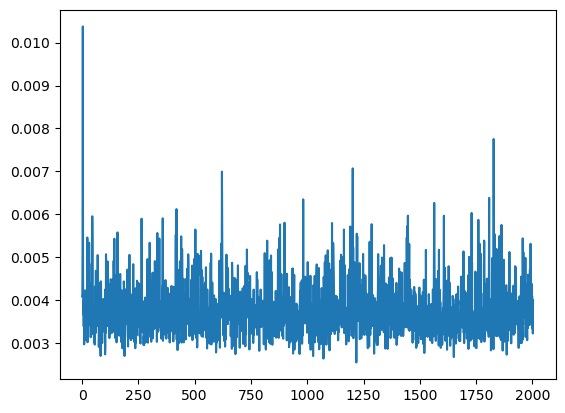

In [21]:
# single-thread continuous version test
a = continuous_screening_csv(r"./fastHDMI/tests/sim/sim_continuous.csv",
                             bw_multiplier=1.1,
                             verbose=2)
assert np.all(a >= 0)

plt.plot(a)
plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:08<00:00, 29.38it/s]


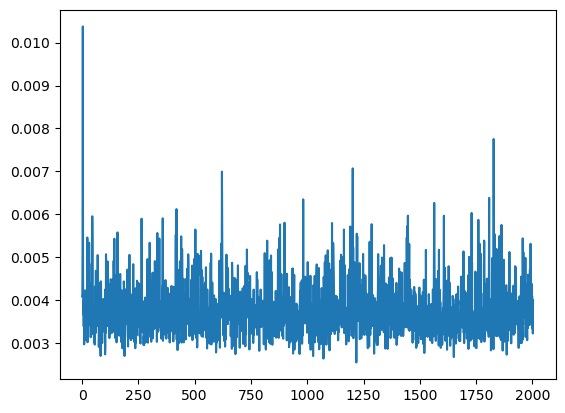

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.62it/s]


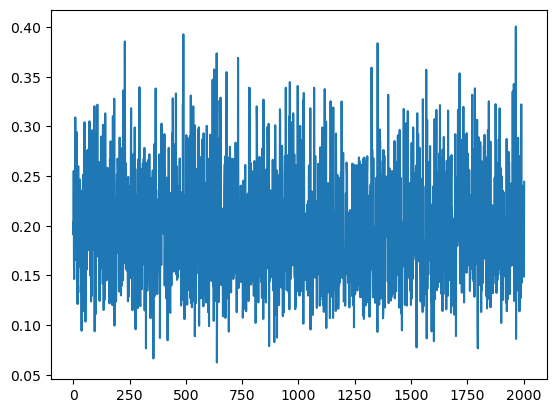

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 31.94it/s]


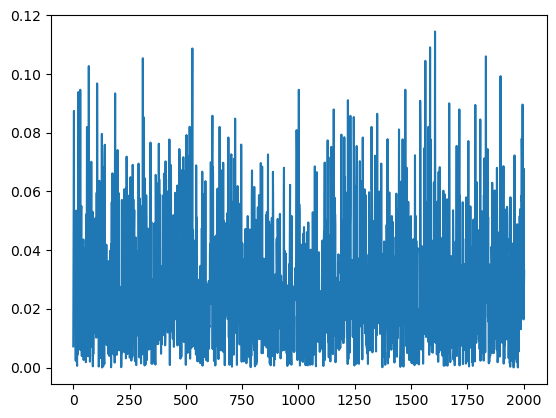

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 31.93it/s]


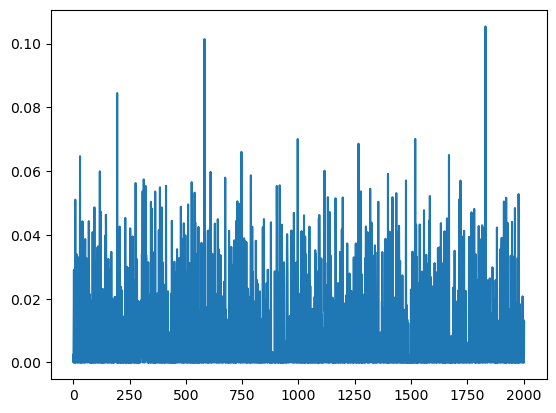

In [22]:
# parallel continuous version test XXX
a = continuous_screening_csv_parallel(
    r"./fastHDMI/tests/sim/sim_continuous.csv", bw_multiplier=1.1, verbose=2)
assert np.all(a >= 0)
plt.plot(a)
plt.show()

a2 = binning_continuous_screening_csv_parallel(
    r"./fastHDMI/tests/sim/sim_continuous.csv", verbose=2)
assert np.all(a2 >= 0)
plt.plot(a2)
plt.show()

b = np.absolute(
    Pearson_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_continuous.csv",
                                   verbose=2))
plt.plot(b)
plt.show()

c = continuous_skMI_screening_csv_parallel(
    r"./fastHDMI/tests/sim/sim_continuous.csv", random_state=0, verbose=2)
assert np.all(c >= 0)
plt.plot(c)
plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|██████████████████████████████████████| 2004/2004 [00:03<00:00, 623.28it/s]


[0.0122652  0.01980875 0.01054247 ... 0.01967505 0.01732598 0.0153061 ]


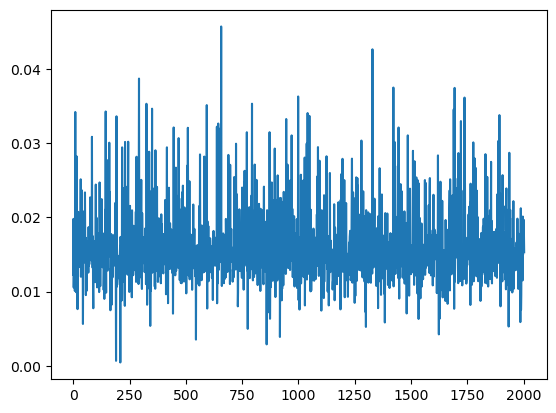

In [23]:
# single-thread binary version for csv
a = binary_screening_csv(r"./fastHDMI/tests/sim/sim_binary.csv", verbose=2)
print(a)
assert np.all(a >= 0)
plt.plot(a)
plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 31.95it/s]


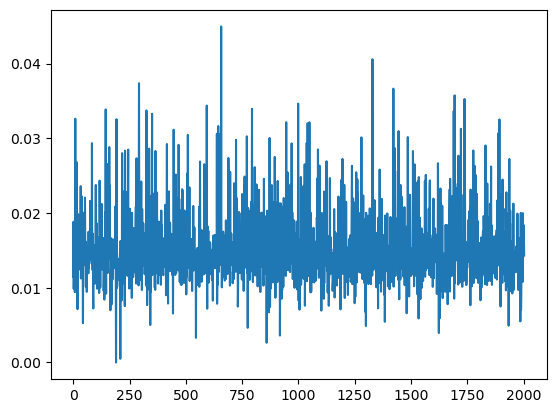

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.37it/s]


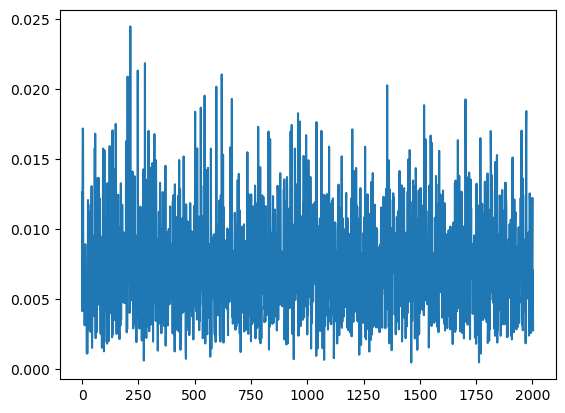

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.32it/s]


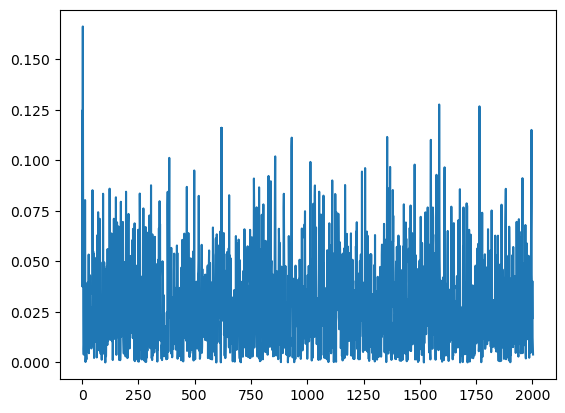

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 34.03it/s]


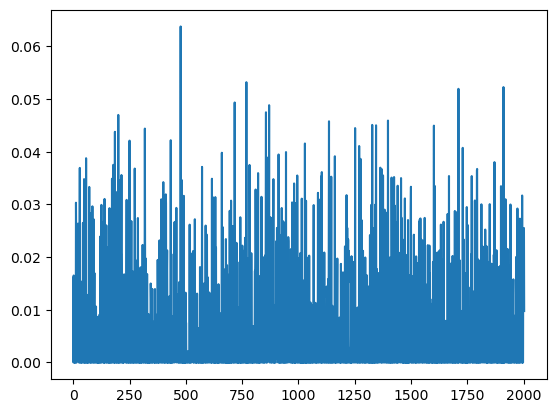

In [24]:
# parallel binary version test
a = binary_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_binary.csv",
                                  bw_multiplier=1.1,
                                  verbose=2)
assert np.all(a >= 0)
plt.plot(a)
plt.show()

a2 = binning_binary_screening_csv_parallel(
    r"./fastHDMI/tests/sim/sim_binary.csv", verbose=2)
assert np.all(a2 >= 0)
plt.plot(a2)
plt.show()

b = np.absolute(
    Pearson_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_binary.csv",
                                   verbose=2))
plt.plot(b)
plt.show()

c = binary_skMI_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_binary.csv",
                                       random_state=0,
                                       verbose=2)
assert np.all(c >= 0)
plt.plot(c)
plt.show()

In [25]:
# test for clumping for CSV files
clump_continuous_csv_parallel(
    csv_file=r"./fastHDMI/tests/sim/sim_continuous.csv",
    bw_multiplier=1.1,
    num_vars_exam=5,
    verbose=2,
)

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████████| 5/5 [00:45<00:00,  9.05s/it]


(4,
 array(['Var 1', 'Var 2', 'Var 3', ..., 'Var 2003', 'Var 2004', 'Var 2005'],
       dtype='<U8'))

## test for `np.array`

100%|█████████████████████████████████████████| 240/240 [00:02<00:00, 80.18it/s]


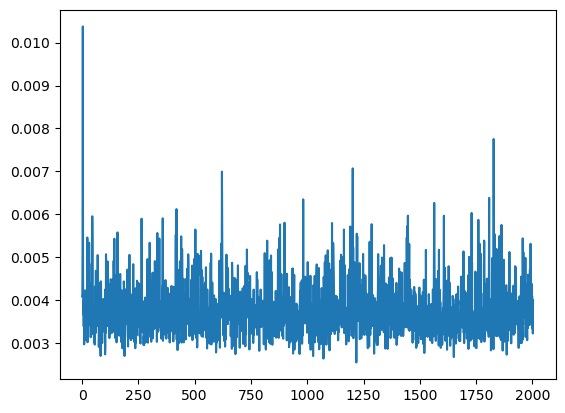

100%|████████████████████████████████████████| 240/240 [00:01<00:00, 185.43it/s]


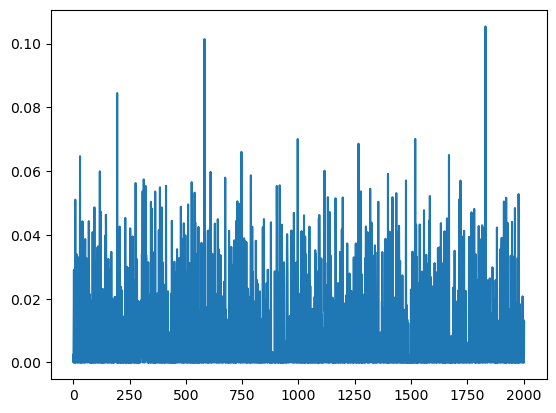

In [26]:
# parallel continuous version but using numpy array
csv = pd.read_csv(r"./fastHDMI/tests/sim/sim_continuous.csv",
                  encoding="unicode_escape",
                  engine="c")
# here it is because pandas reads the first column as the index
X, y = csv.iloc[:, 2:].to_numpy(), csv.iloc[:, 1].to_numpy()

MI = continuous_screening_array_parallel(X, y, bw_multiplier=1.1, verbose=2)
assert np.all(MI >= 0)
plt.plot(MI)
plt.show()

skMI = continuous_skMI_array_parallel(X,
                                      y,
                                      n_neighbors=3,
                                      random_state=0,
                                      verbose=2)
assert np.all(skMI >= 0)
plt.plot(skMI)
plt.show()